In [5]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy


from dataset import CUBDataset, DOGDataset

In [6]:
from torch.utils.data import random_split

data_root = "./CUB_200_2011"

mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)


# write data transform here as per the requirement
train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(0.1),
        # transforms.RandomRotation(45),
        # transforms.RandomCrop(224, padding=4),
        # transforms.ColorJitter(0.1, 0.1, 0.1, 0.1),
        transforms.RandomAffine(45, (0.3, 0.3), (2, 2)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

train_dataset = CUBDataset(image_root_path=f"{data_root}", transform=train_transform, split="train")
test_dataset = CUBDataset(image_root_path=f"{data_root}", transform=test_transform, split="test")


train_split = int(len(train_dataset) * 0.8)
val_split = len(train_dataset) - train_split
train_ds, val_ds = random_split(train_dataset, [train_split, val_split])


batch_size = 64
# load in into the torch dataloader to get variable batch size, shuffle 
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, num_workers=1, drop_last=True, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=batch_size, num_workers=1, drop_last=True, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=1, drop_last=False, shuffle=True)

In [7]:
print( len(train_dataset), len(test_dataset) )
print( len(train_loader), len(test_loader) )

5994 5794
74 91


In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [9]:
for i, (inputs, labels) in enumerate(train_loader):
    print(inputs.shape)
    print(labels)
    print('='*50)
    break



torch.Size([64, 3, 224, 224])
tensor([177,  12, 189, 184,  94,  39,  53,  50,  82, 116, 183, 183,  36,  16,
         53,  61, 117, 166,  70, 145,  34,   7, 137,  28,  30, 174,  54, 191,
         28, 161, 172,  12,  99,   9, 110, 150,  42, 139,  76,  42, 139, 157,
          2,  25, 139, 146, 121, 195, 171,  62, 112, 190,  22, 162, 191, 160,
        158, 134,  84,  52,   8, 186, 198,  90])


In [89]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

def initialize_model(num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

#     if model_name == "resnet101":
    model_ft = models.resnet50(pretrained=True, progress=True)
#     print(model_ft)
    # FREEZE GRADIENTS OF ALL LAYERS
    set_parameter_requires_grad(model_ft, True)
    # model_ft.layer3[0].conv1 = nn.Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1), bias=False, dilation=2)
    # model_ft.layer3[1].conv1 = nn.Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False, dilation=3)

    # FEATURES FROM THE FINAL LAYER WITH REQUIRES_GRAD = TRUE
    # CHANGE CLASS NUMBER FOR FC AND ADD DROPOUT
    model_ft.fc = nn.Sequential(
#         nn.Linear(1024, 2048),
# #         nn.ReLU(
        nn.Dropout(0.5),
        nn.Linear(2048,200)
    )  
#     print(model_ft)
#     num_ftrs = model_ft.fc.in_features
#     model_ft.fc = nn.Linear(num_ftrs, num_classes)
#     input_size = 224

    return model_ft, input_size

In [90]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
# Number of classes in the dataset
num_classes = 200
learning_rate = 0.0001
num_epochs = 30
# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True
# Initialize the model for this run
model, input_size = initialize_model(num_classes, feature_extract, use_pretrained=True)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [91]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 409,800 trainable parameters


In [92]:
if torch.cuda.is_available():
    model.cuda()

In [93]:
params_to_update = model.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param) # PARAMS OF FINAL LAYER TO UPDATE WITH THE OPTIMIZER
            print("\t",name)
else:
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

Params to learn:
	 fc.1.weight
	 fc.1.bias


In [94]:
# Loss and optimizer
# ADAM

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params_to_update, lr=learning_rate)
# Observe that all parameters are being optimized
# optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

# For updating learning rate
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [95]:
# Train the model
total_step = len(train_loader)
curr_lr = learning_rate
# val_losses = np.array([])
# train_losses = np.array([])
val_losses = []
train_losses = []

val_acc = []
train_acc = []

myfile = open('myfile__resnet50_txt', 'w')
myfile.write('Training results: \n')

for epoch in range(num_epochs):
    running_loss = 0
    correct=0
    total=0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        # print(images.shape)
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimizes
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        if (i+1) % 10 == 0:
            print ("Epoch [{}/{}], Step [{}/{}] Train Loss: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    train_loss = running_loss / len(train_loader)
    acc = 100.*correct/total

    train_losses.append(train_loss)
    train_acc.append(acc)
    print('Train loss at epoch {} is {:.4f}'.format(epoch+1, train_loss))
    print('Train acc at epoch {} is {:.4f}'.format(epoch+1, acc))
    myfile.write('Train loss at epoch {} is {:.4f}\n'.format(epoch+1, train_loss))
    myfile.write('Train acc at epoch {} is {:.4f}\n'.format(epoch+1, acc))

    model.eval()
    running_loss = 0
    with torch.no_grad():
        for i, (images, labels) in enumerate(val_loader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    val_loss = loss / len(val_loader) 
    acc = 100.*correct/total
    val_losses.append(val_loss)
    val_acc.append(acc)
    print('Val loss at epoch {} is {:.4f}'.format(epoch+1, val_loss))
    print('Val acc at epoch {} is {:.4f}'.format(epoch+1, acc))
    myfile.write('Val loss at epoch {} is {:.4f}\n'.format(epoch+1, val_loss))
    myfile.write('Val acc at epoch {} is {:.4f}\n'.format(epoch+1, acc))    

    # Decay learning rate
    if (epoch+1) % 10 == 0:
        curr_lr /= 3
        update_lr(optimizer, curr_lr)


myfile.close()



Epoch [1/30], Step [10/74] Train Loss: 5.3589
Epoch [1/30], Step [20/74] Train Loss: 5.3861
Epoch [1/30], Step [30/74] Train Loss: 5.3851
Epoch [1/30], Step [40/74] Train Loss: 5.4038
Epoch [1/30], Step [50/74] Train Loss: 5.2859
Epoch [1/30], Step [60/74] Train Loss: 5.3651
Epoch [1/30], Step [70/74] Train Loss: 5.2957
Train loss at epoch 1 is 5.3583
Train acc at epoch 1 is 0.7601
Val loss at epoch 1 is 0.2920
Val acc at epoch 1 is 0.9511
Epoch [2/30], Step [10/74] Train Loss: 5.1081
Epoch [2/30], Step [20/74] Train Loss: 5.1173
Epoch [2/30], Step [30/74] Train Loss: 5.1067
Epoch [2/30], Step [40/74] Train Loss: 5.0703
Epoch [2/30], Step [50/74] Train Loss: 5.0688
Epoch [2/30], Step [60/74] Train Loss: 5.0539
Epoch [2/30], Step [70/74] Train Loss: 5.0936
Train loss at epoch 2 is 5.0959
Train acc at epoch 2 is 4.2019
Val loss at epoch 2 is 0.2831
Val acc at epoch 2 is 4.3308
Epoch [3/30], Step [10/74] Train Loss: 4.9548
Epoch [3/30], Step [20/74] Train Loss: 4.9337
Epoch [3/30], Step [

Epoch [19/30], Step [30/74] Train Loss: 3.4985
Epoch [19/30], Step [40/74] Train Loss: 3.4080
Epoch [19/30], Step [50/74] Train Loss: 3.2782
Epoch [19/30], Step [60/74] Train Loss: 3.3439
Epoch [19/30], Step [70/74] Train Loss: 3.2578
Train loss at epoch 19 is 3.3795
Train acc at epoch 19 is 51.2458
Val loss at epoch 19 is 0.2100
Val acc at epoch 19 is 47.6902
Epoch [20/30], Step [10/74] Train Loss: 3.3123
Epoch [20/30], Step [20/74] Train Loss: 3.3863
Epoch [20/30], Step [30/74] Train Loss: 3.3841
Epoch [20/30], Step [40/74] Train Loss: 3.3221
Epoch [20/30], Step [50/74] Train Loss: 3.3284
Epoch [20/30], Step [60/74] Train Loss: 3.1377
Epoch [20/30], Step [70/74] Train Loss: 3.2472
Train loss at epoch 20 is 3.3642
Train acc at epoch 20 is 50.4856
Val loss at epoch 20 is 0.2052
Val acc at epoch 20 is 47.1807
Epoch [21/30], Step [10/74] Train Loss: 3.3664
Epoch [21/30], Step [20/74] Train Loss: 3.2911
Epoch [21/30], Step [30/74] Train Loss: 3.2064
Epoch [21/30], Step [40/74] Train Loss:

In [96]:
torch.save(model.state_dict(), 'model_checkpoints/model_resnet50.pth')


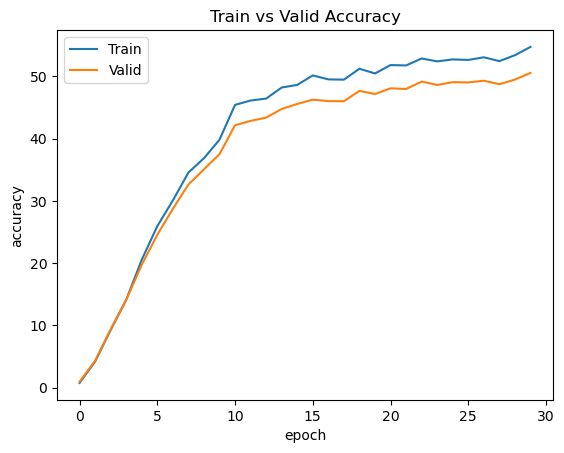

In [97]:
plt.plot(train_acc)
plt.plot(val_acc)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')

plt.show()


In [99]:
 # Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))

# # Save the model checkpoint
# torch.save(model.state_dict(), model.name + '.ckpt')

Accuracy of the model on the test images: 33.59375 %
